In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.data import Dataset
from google.colab import files



---


Applying polynomial feature transformation and L2 regularization

---



Epoch 1/20
109/109 [==============================] - 7s 31ms/step - loss: 1.1580 - accuracy: 0.7698 - val_loss: 0.6843 - val_accuracy: 0.7648
Epoch 2/20
109/109 [==============================] - 3s 25ms/step - loss: 0.5730 - accuracy: 0.7849 - val_loss: 0.5391 - val_accuracy: 0.7671
Epoch 3/20
109/109 [==============================] - 2s 19ms/step - loss: 0.5182 - accuracy: 0.7849 - val_loss: 0.5170 - val_accuracy: 0.7614
Epoch 4/20
109/109 [==============================] - 2s 19ms/step - loss: 0.5012 - accuracy: 0.7886 - val_loss: 0.5306 - val_accuracy: 0.7677
Epoch 5/20
109/109 [==============================] - 3s 25ms/step - loss: 0.4988 - accuracy: 0.7870 - val_loss: 0.5164 - val_accuracy: 0.7734
Epoch 6/20
109/109 [==============================] - 4s 32ms/step - loss: 0.4902 - accuracy: 0.7931 - val_loss: 0.5082 - val_accuracy: 0.7723
Epoch 7/20
109/109 [==============================] - 3s 22ms/step - loss: 0.4899 - accuracy: 0.7882 - val_loss: 0.5038 - val_accuracy: 0.7752

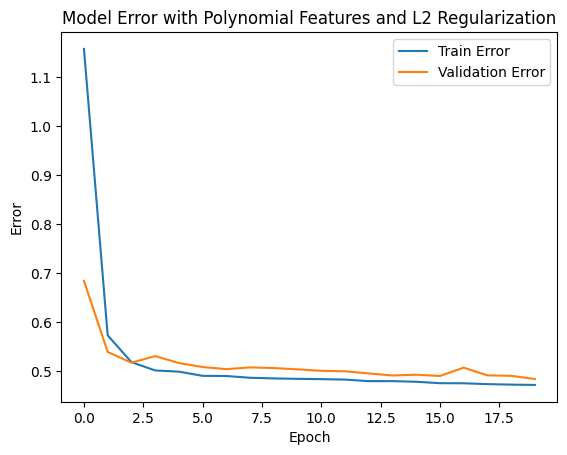

In [3]:
# Load data
train_data = pd.read_csv('train.csv')

# Prepare features and target
X = train_data.drop(['Transported', 'Name', 'PassengerId'], axis=1)
y = train_data['Transported'].astype(int)

# Define numerical and categorical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# Function to ensure dense output
def to_dense(X):
    if hasattr(X, "toarray"):
        return X.toarray()
    return X

# Preprocessing for numerical data with Polynomial Features
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    FunctionTransformer(to_dense)  # Ensure dense output
)

# Preprocessing for categorical data
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False),
    FunctionTransformer(to_dense)  # Explicit dense conversion, if needed
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = np.array(X_preprocessed)  # Ensuring it's a dense numpy array
y = np.array(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Convert to TensorFlow Dataset
train_dataset = Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=10000).batch(64).prefetch(1)
val_dataset = Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

# Neural network model with L2 Regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Model Error with Polynomial Features and L2 Regularization')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [4]:
# Functions to evaluate precision and recall
def compute_metrics(model, X, y_true):
    y_pred = (model.predict(X) > 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall

# Parameters to vary
l2_reg_values = [0.01, 0.1, 0.5]  # Example regularization strengths

results = []

for l2 in l2_reg_values:
    # Create the neural network model with L2 Regularization
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=0)

    # Evaluate the model
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    precision, recall = compute_metrics(model, X_val, y_val)

    # Store results
    results.append({'Lambda': l2, 'Train Accuracy': train_acc,
                    'Validation Accuracy': val_acc, 'Precision': precision, 'Recall': recall})

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

print(results_df)

55/55 [==============================] - 0s 6ms/step
   Lambda  Train Accuracy  Validation Accuracy  Precision    Recall
0    0.01        0.794794             0.775733   0.787059  0.761959
1    0.10        0.782859             0.768833   0.744353  0.825740
2    0.50        0.769485             0.766532   0.800254  0.716401




---


Applying log transformation and dropout regularization


---



Epoch 1/20
109/109 [==============================] - 4s 28ms/step - loss: 1.1477 - accuracy: 0.7458 - val_loss: 0.6530 - val_accuracy: 0.7700
Epoch 2/20
109/109 [==============================] - 2s 20ms/step - loss: 0.5811 - accuracy: 0.7728 - val_loss: 0.5418 - val_accuracy: 0.7706
Epoch 3/20
109/109 [==============================] - 2s 18ms/step - loss: 0.5332 - accuracy: 0.7726 - val_loss: 0.5281 - val_accuracy: 0.7677
Epoch 4/20
109/109 [==============================] - 2s 17ms/step - loss: 0.5239 - accuracy: 0.7784 - val_loss: 0.5233 - val_accuracy: 0.7711
Epoch 5/20
109/109 [==============================] - 2s 16ms/step - loss: 0.5196 - accuracy: 0.7770 - val_loss: 0.5214 - val_accuracy: 0.7763
Epoch 6/20
109/109 [==============================] - 2s 23ms/step - loss: 0.5190 - accuracy: 0.7745 - val_loss: 0.5202 - val_accuracy: 0.7700
Epoch 7/20
109/109 [==============================] - 2s 16ms/step - loss: 0.5196 - accuracy: 0.7767 - val_loss: 0.5175 - val_accuracy: 0.7763

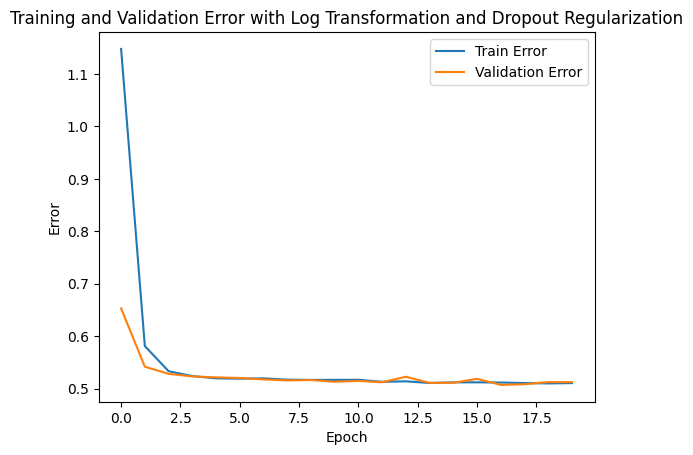

In [5]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing to do here

    def transform(self, X, y=None):
        return np.log1p(X)  # Applies log(1 + x) to handle zero values safely

# Function to convert sparse matrix to dense
def to_dense(X):
    if hasattr(X, "toarray"):
        return X.toarray()
    return X

# Load data
train_data = pd.read_csv('train.csv')

# Prepare features and target
X = train_data.drop(['Transported', 'Name', 'PassengerId'], axis=1)
y = train_data['Transported'].astype(int)

# Define numerical and categorical features
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# Preprocessing for numerical data with Log Transformation
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', LogTransformer()),
    ('scaler', StandardScaler()),
    ('to_dense', FunctionTransformer(to_dense, validate=False))  # Ensure dense output
])

# Preprocessing for categorical data
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('to_dense', FunctionTransformer(to_dense, validate=False))  # Ensure dense output
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = np.array(X_preprocessed)  # Ensuring it's a dense numpy array
y = np.array(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=10000).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)

# Neural network model with Dropout
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

# Visualizing the training and validation loss
plt.plot(history.history['loss'], label='Train Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Training and Validation Error with Log Transformation and Dropout Regularization')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [6]:
# Different values of L2 regularization strength (lambda)
l2_strengths = [0.01, 0.1, 0.5]

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=["Lambda", "Train Accuracy", "Validation Accuracy", "Precision", "Recall"])

for l2 in l2_strengths:
    # Define the neural network model with variable L2 regularization
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=0)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=0)

    # Make predictions to compute precision and recall
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # Create a DataFrame for the current model's results
    current_results = pd.DataFrame({
        "Lambda": [l2],
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Precision": [precision],
        "Recall": [recall]
    })

    # Append results to the main DataFrame
    results_df = pd.concat([results_df, current_results], ignore_index=True)

# Display the results table
print(results_df)

55/55 [==============================] - 0s 5ms/step
   Lambda  Train Accuracy  Validation Accuracy  Precision    Recall
0    0.01        0.788036             0.778033   0.781465  0.777904
1    0.10        0.770492             0.769408   0.768884  0.776765
2    0.50        0.496693             0.495112   0.000000  0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
